In [1]:
import numpy as np
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from pylab import *
import networkx as nx
import scipy
from scipy.stats import linregress,lognorm,rv_continuous,powerlaw,invgamma,ks_2samp,expon,lognorm,pareto,weibull_min,fisk,poisson
import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import collections

%matplotlib inline

In [2]:
os.chdir('C:\\Users\\euler\\Documents\\Project\\Structure\\OneDrive_2020-05-31\\Global Structure')
network = pd.read_table('rxn_network_w_modules.txt')
reg_network = pd.read_csv('gephi_reg.csv')
rxn_network = pd.read_csv('gephi_rxn.csv')

In [3]:
#Make graph structure from network data
G = nx.DiGraph()
G_rxn = nx.DiGraph()
G_reg = nx.DiGraph()

for i,row in network.iterrows():
    G.add_edge(row['start'],row['end'])
    
    if row['type'] == 'inhibition' or row['type'] == 'activation':
        G_reg.add_edge(row['start'],row['end'],mode=row['type'])
    else:
        G_rxn.add_edge(row['start'],row['end'])

In [4]:
def loop_nodes(G):
    
    loop_nodes = []
    
    for node in G.nodes: #For each node
        neighbors = [x for x in G.neighbors(node)] #Find neighbors
        
        if node in neighbors: #Remove self from neighbors to avoid self-loops
            neighbors.remove(node)
        
        for neighbor in neighbors: #For each neighbor
            thirds = set(neighbors).intersection(set([x for x in G.neighbors(neighbor)])) #Find shared neighbors of node
            thirds = list(thirds)
            
            if neighbor in thirds: #Avoid self-loops
                thirds.remove(neighbor)
            
            if len(thirds) == 0: #If there are no shared neighbours, don't do anything
                continue
            else:
                if node not in loop_nodes: #If there are, add the node to the list of nodes in loops
                    loop_nodes.append(node)
                for x in neighbors:
                    if x not in loop_nodes:
                        loop_nodes.append(x) #Add coordinating nodes to lits of nodes in loops
                for x in thirds: #Add output nodes to the list of nodes in loops
                    if x not in loop_nodes:
                        loop_nodes.append(x)
    return loop_nodes

#Note: overestimates loop abundance because it does not account for low-dimensional loops. In our representation of the
#regulatory network, metabolite information is embedded in edges. If two reactions produce the same metabolite and it is an
#effector of one of those reactions, then the structure is the same as the loops we investigate, but the dynamics are different
#than what we describe in our model. For enrichment of loops, this is probably fine, because it will overestimate by the same
#amount for each randomized network.

In [5]:
def characterize_loops(G):
    
    tally = [0,0,0,0,0,0,0,0] #C1, C2, C3, C4, I1, I2, I3, I4
    loops = [[],[],[],[],[],[],[],[]] 
    
    for node in G.nodes: #For each node
        neighbors = [x for x in G.neighbors(node)] #Find neighbors
        
        if node in neighbors: #Remove self from neighbors to avoid self-loops
            neighbors.remove(node)
        
        if 'pp' in node[-2:]:
            continue
        
        for neighbor in neighbors: #For each neighbor
            thirds = set(neighbors).intersection(set([x for x in G.neighbors(neighbor)])) #Find shared neighbors of node
            thirds = list(thirds)
            
            if neighbor in thirds: #Avoid self-loops
                thirds.remove(neighbor)
            
            if 'pp' in neighbor[-2:]:
                continue
            
            for third in thirds:
                if 'pp' in third[-2:]:
                    continue
                    
                matrix = [G.get_edge_data(node, neighbor)['mode'],G.get_edge_data(node, third)['mode'],
                          G.get_edge_data(neighbor, third)['mode']]

                if matrix == ['activation','activation','activation']:
                    tally[0] = tally[0] + 1
                    loops[0].append([node,neighbor,third])
                if matrix == ['inhibition','inhibition','activation']:
                    tally[1] = tally[1] + 1
                    loops[1].append([node,neighbor,third])
                if matrix == ['activation','inhibition','activation']:
                    tally[2] = tally[2] + 1
                    loops[2].append([node,neighbor,third])
                if matrix == ['inhibition','activation','inhibition']:
                    tally[3] = tally[3] + 1
                    loops[3].append([node,neighbor,third])
                if matrix == ['activation','activation','inhibition']:
                    tally[4] = tally[4] + 1
                    loops[4].append([node,neighbor,third])
                if matrix == ['inhibition','inhibition','inhibition']:
                    tally[5] = tally[5] + 1
                    loops[5].append([node,neighbor,third])
                if matrix == ['activation','inhibition','activation']:
                    tally[6] = tally[6] + 1
                    loops[6].append([node,neighbor,third])
                if matrix == ['inhibition','activation','activation']:
                    tally[7] = tally[7] + 1
                    loops[7].append([node,neighbor,third])
                       
    return tally, loops

In [6]:
def construct(p_add, p_remove,G_rxn, G_reg):
    
    G = nx.DiGraph()
    G.add_nodes_from(G_reg.nodes)
    
    while len(G.edges()) < len(G_reg.edges()):
        
        node = random.choice(list(G.nodes()))
           
                        
        if random.random() < p_add:
            overlap = list(set(G.nodes).intersection(set(G_rxn.nodes())))
            new = random.choice(overlap)
            
            predecessors = [x for x in G_rxn.predecessors(new)]

            if random.random() < 0.8:
                for predecessor in predecessors:
                    G.add_edge(predecessor,node,mode='neg')
            else:
                for predecessor in predecessors:
                    G.add_edge(predecessor,node,mode='pos')
        
        node = random.choice(list(G.nodes()))
        
        if random.random() < p_add:
            overlap = list(set(G.nodes).intersection(set(G_rxn.nodes())))
            new = random.choice(overlap)
            predecessors = [x for x in G_rxn.predecessors(new)]
            
            if random.random() < 0.8:
                for predecessor in predecessors:
                    G.add_edge(predecessor,node, mode='inhibition')
            else:
                for predecessor in predecessors:
                    G.add_edge(predecessor,node,mode='activation')
        
        node = random.choice(list(G.nodes()))
        
        if random.random() < p_remove:
            in_edges = [x for x in G.in_edges(node)]
                
            for x in in_edges:
                G.remove_edge(x[0],x[1])
                
    return G

In [7]:
def merge_networks(G1,G2):

    edges1 = [x for x in G1.edges]
    edges2 = [x for x in G2.edges]
    
    G_merged = nx.DiGraph()
    G_merged.add_edges_from(edges1)
    G_merged.add_edges_from(edges2)
    
    return G_merged

In [8]:
def randomize(G):

    G_copy = G.copy()

    for i in range(0,4*len(G.edges())):

        e1 = random.choice([x for x in G_copy.edges])
        e2 = random.choice([x for x in G_copy.edges])

        e1_mode = G_copy.get_edge_data(e1[0],e1[1])['mode']
        e2_mode = G_copy.get_edge_data(e2[0],e2[1])['mode']

        if e1[0] != e2[0] and e1[1] != e2[1] and e1[0] != e2[1] and e1[1] != e2[0]:
            if (e1[0],e2[1]) not in [x for x in G_copy.edges] and (e2[0],e1[1]) not in [x for x in G_copy.edges]:

                G_copy.remove_edge(e1[0],e1[1])
                G_copy.add_edge(e1[0],e2[1],mode=e1_mode)

                G_copy.remove_edge(e2[0],e2[1])
                G_copy.add_edge(e2[0],e1[1],mode=e2_mode)

    return G_copy

# Make Ensemble

In [9]:
p_in = []
p_out = []
ensemble = []

i = 0 

while len(p_in) < 1000:
    G_test = randomize(G_reg)#construct(0.75,0.5,G_rxn,G_reg)
    
    ensemble.append(G_test)
    
    p_in.append(scipy.stats.ks_2samp(random.sample(list(reg_network['indegree']),100),
                                     random.sample([x[1] for x in G_test.in_degree],100)).pvalue)
    p_out.append(scipy.stats.ks_2samp(random.sample(list(reg_network['outdegree']),100),
                                      random.sample([x[1] for x in G_test.out_degree],100)).pvalue)
    
    i = i +1
    print(i,end='\r')

In [10]:
1-len([x for x in p_in if x>=0.05])/len(p_in)

0.0050000000000000044

In [11]:
scipy.stats.ks_2samp([x[1] for x in ensemble[0].in_degree],reg_network['indegree'])

Ks_2sampResult(statistic=0.0, pvalue=1.0)

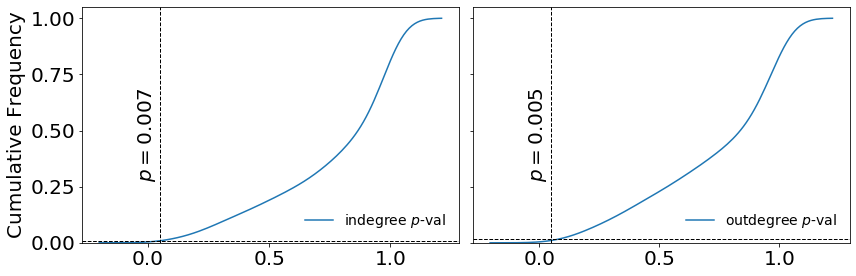

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4),sharey=True)

ax=ax.flatten()

ax[0] = sns.kdeplot(p_in,ax=ax[0],label=r'indegree $p$-val',cumulative=True)

ax[1] = sns.kdeplot(p_out,ax=ax[1],label=r'outdegree $p$-val',cumulative=True)

#ax.set_xlabel(r'Degree',fontsize=20)
ax[0].set_ylabel('Cumulative Frequency',fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].legend(frameon=False,fontsize=14)
ax[0].axvline(0.05,linewidth=1,linestyle='--',color='k')
ax[0].axhline(0.007,linewidth=1,linestyle='--',color='k')
ax[0].text(-0.05,0.3,r'$p=0.007$',rotation=90,fontsize=20)

ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].legend(frameon=False,fontsize=14)
ax[1].axvline(0.05,linewidth=1,linestyle='--',color='k')
ax[1].axhline(0.015,linewidth=1,linestyle='--',color='k')
ax[1].text(-0.05,0.3,r'$p=0.005$',rotation=90,fontsize=20)
plt.tight_layout()

plt.savefig('p_dists.pdf',bbox_inches='tight')

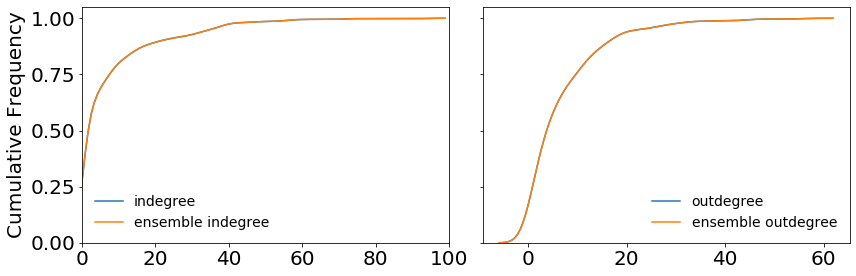

In [13]:
fig, ax = plt.subplots(1,2,figsize=(12,4),sharey=True)

ax=ax.flatten()

ax[0] = sns.kdeplot(reg_network['indegree'],cumulative=True,ax =ax[0])
ax[0] = sns.kdeplot([x[1] for x in ensemble[0].in_degree],cumulative=True,ax=ax[0],label='ensemble indegree')

ax[1] = sns.kdeplot(reg_network['outdegree'],ax=ax[1],cumulative=True)
ax[1] = sns.kdeplot([x[1] for x in ensemble[0].out_degree],cumulative=True,ax=ax[1],label='ensemble outdegree')

#ax.set_xlabel(r'Degree',fontsize=20)
ax[0].set_ylabel('Cumulative Frequency',fontsize=20)
ax[0].set_xlim(0,100)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].legend(frameon=False,fontsize=14)

ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].legend(frameon=False,fontsize=14)
plt.tight_layout()

#plt.savefig('cum_dists.pdf',bbox_inches='tight')

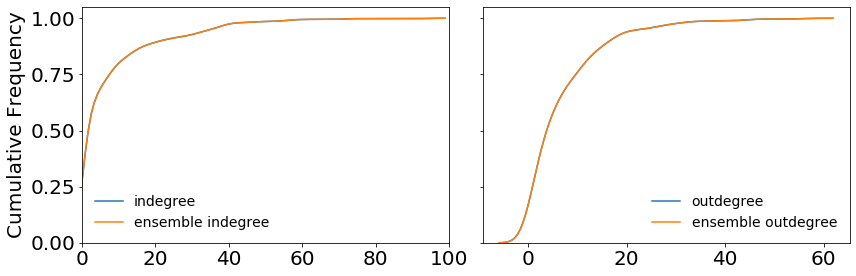

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,4),sharey=True)

ax=ax.flatten()

ax[0] = sns.kdeplot(reg_network['indegree'],cumulative=True,ax =ax[0])
ax[0] = sns.kdeplot([x[1] for x in ensemble[0].in_degree],cumulative=True,ax=ax[0],label='ensemble indegree')

ax[1] = sns.kdeplot(reg_network['outdegree'],ax=ax[1],cumulative=True)
ax[1] = sns.kdeplot([x[1] for x in ensemble[0].out_degree],cumulative=True,ax=ax[1],label='ensemble outdegree')

#ax.set_xlabel(r'Degree',fontsize=20)
ax[0].set_ylabel('Cumulative Frequency',fontsize=20)
ax[0].set_xlim(0,100)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].legend(frameon=False,fontsize=14)

ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].legend(frameon=False,fontsize=14)
plt.tight_layout()

#plt.savefig('cum_dists.pdf',bbox_inches='tight')

# Topology Analysis

In [15]:
H_merged = merge_networks(G_reg,G_rxn).to_undirected()
H_rxn = G_rxn.to_undirected()
H_reg = G_reg.to_undirected()
H_rand = merge_networks(ensemble[0],G_rxn).to_undirected()

In [16]:
Ot = pd.DataFrame(columns = [node for node in H_reg],index = [node for node in H_reg])

for node in H_reg: #Go thru each node in the reg network
    for rxn in H_reg:
        if node == rxn:
            Ot[node][rxn] = 0.
        elif len(sorted(nx.common_neighbors(H_reg,node,rxn)))>0:
            neighbors = sorted(nx.common_neighbors(H_reg,node,rxn)) #Find common neighbours for each adjacent node
            node_deg = float(reg_network[reg_network['Id']==node].Degree)
            rxn_deg = float(reg_network[reg_network['Id']==rxn].Degree)
            m = min(node_deg,rxn_deg)
            Ot[node][rxn] = float(len(neighbors)/m)
        else:
            Ot[node][rxn] = 0.
            
Ot = Ot.astype(float)

In [17]:
Otr = pd.DataFrame(columns = [node for node in H_rxn],index = [node for node in H_rxn])

for node in H_rxn: #Go thru each node in the reg network
    for rxn in H_rxn:
        if node == rxn:
            Otr[node][rxn] = 0.
        elif len(sorted(nx.common_neighbors(H_rxn,node,rxn)))>0:
            neighbors = sorted(nx.common_neighbors(H_rxn,node,rxn)) #Find common neighbours for each adjacent node
            node_deg = float(rxn_network[rxn_network['Id']==node].Degree)
            rxn_deg = float(rxn_network[rxn_network['Id']==rxn].Degree)
            m = min(node_deg,rxn_deg)
            Otr[node][rxn] = float(len(neighbors)/m)
        else:
            Otr[node][rxn] = 0.

Otr = Otr.astype(float)

In [18]:
Otm = pd.DataFrame(columns = [node for node in H_merged],index = [node for node in H_merged])

for node in H_merged: #Go thru each node in the reg network
    for rxn in H_merged:
        if node == rxn:
            Otm[node][rxn] = 0.
        elif len(sorted(nx.common_neighbors(H_merged,node,rxn)))>0:
            neighbors = sorted(nx.common_neighbors(H_merged,node,rxn)) #Find common neighbours for each adjacent node
            node_deg = float(H_merged.degree(node))
            rxn_deg = float(H_merged.degree(rxn))
            m = min(node_deg,rxn_deg)
            Otm[node][rxn] = float(len(neighbors)/m)
        else:
            Otm[node][rxn] = 0.

Otm = Otm.astype(float)

In [19]:
Otrand = pd.DataFrame(columns = [node for node in H_rand],index = [node for node in H_rand])

for node in H_rand: #Go thru each node in the reg network
    for rxn in H_rand:
        if node == rxn:
            Otm[node][rxn] = 0.
        elif len(sorted(nx.common_neighbors(H_rand,node,rxn)))>0:
            neighbors = sorted(nx.common_neighbors(H_rand,node,rxn)) #Find common neighbours for each adjacent node
            node_deg = float(H_rand.degree(node))
            rxn_deg = float(H_rand.degree(rxn))
            m = min(node_deg,rxn_deg)
            
            if m == 0:
                Otrand[node][rxn] = 0.
            else:
                Otrand[node][rxn] = float(len(neighbors)/m)
        else:
            Otrand[node][rxn] = 0.

Otrand = Otrand.astype(float)

C:\Users\euler\anaconda3\lib\site-packages\seaborn\matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
C:\Users\euler\anaconda3\lib\site-packages\seaborn\matrix.py:595: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


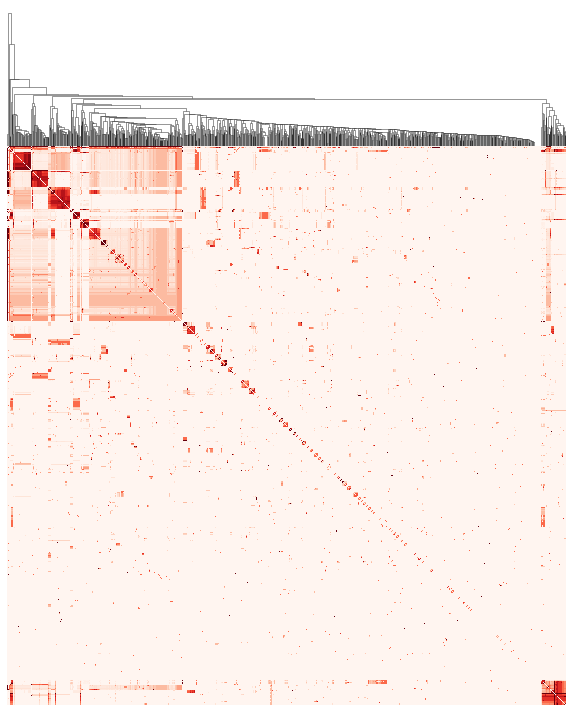

In [20]:
gr = sns.clustermap(Otr.reset_index(drop=True),cmap='Reds',
                    #row_colors=reg_row_colors,
                    linewidths=0, 
                    xticklabels=False, yticklabels=False)

gr.ax_row_dendrogram.set_visible(False)
gr.ax_col_dendrogram.set_visible(True)

gr.cax.set_visible(False)
#plt.savefig('TOM_rxn.pdf',bbox_inches='tight')

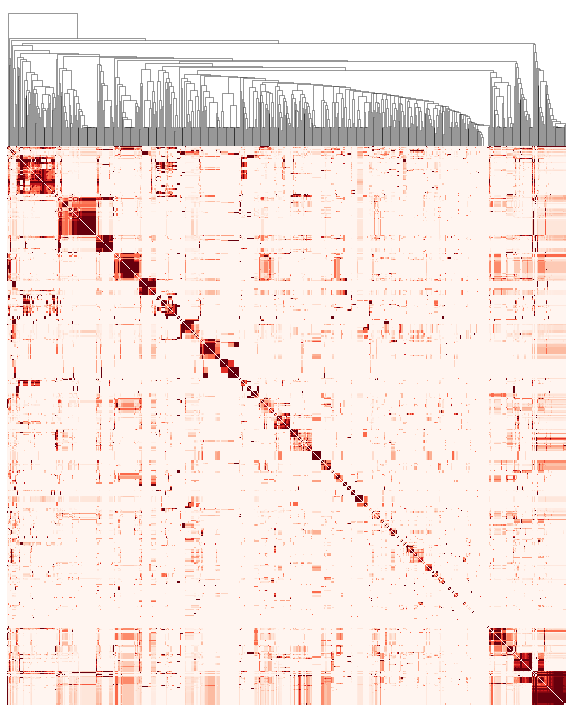

In [21]:
gr = sns.clustermap(Ot.reset_index(drop=True),cmap='Reds',
                    #row_colors=reg_row_colors,
                    linewidths=0, 
                    xticklabels=False, yticklabels=False)

gr.ax_row_dendrogram.set_visible(False)
gr.ax_col_dendrogram.set_visible(True)

gr.cax.set_visible(False)
#plt.savefig('TOM_reg.pdf',bbox_inches='tight')

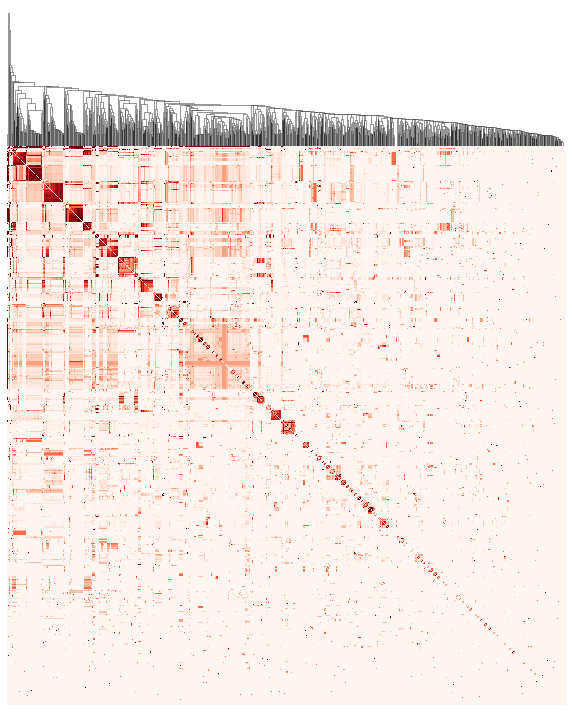

In [22]:
gr = sns.clustermap(Otm.reset_index(drop=True),cmap='Reds',
                    #row_colors=reg_row_colors,
                    linewidths=0, 
                    xticklabels=False, yticklabels=False)

gr.ax_row_dendrogram.set_visible(False)
gr.ax_col_dendrogram.set_visible(True)

gr.cax.set_visible(False)
#plt.savefig('TOM_int.pdf',bbox_inches='tight')

In [23]:
Otrand.fillna(0.0,inplace=True)

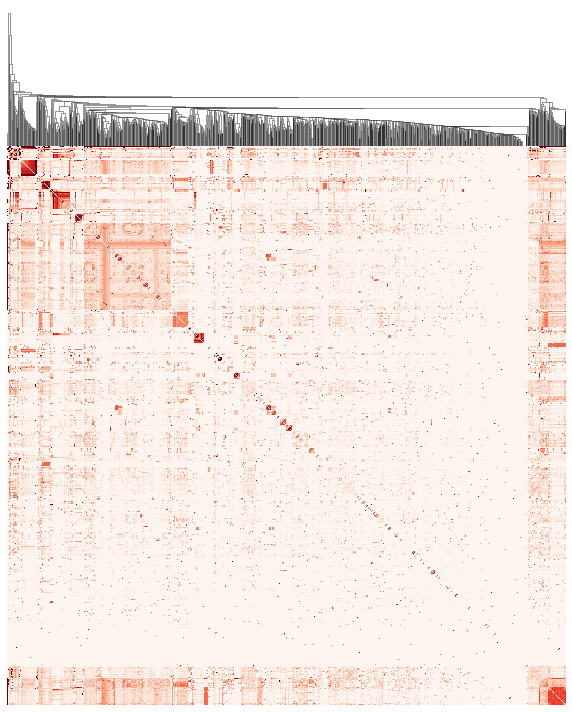

In [24]:
gr = sns.clustermap(Otrand.reset_index(drop=True),cmap='Reds',
                    #row_colors=reg_row_colors,
                    linewidths=0, 
                    xticklabels=False, yticklabels=False)

gr.ax_row_dendrogram.set_visible(False)
gr.ax_col_dendrogram.set_visible(True)

gr.cax.set_visible(False)
#plt.savefig('TOM_rand.pdf',bbox_inches='tight')

(0, 0.2)

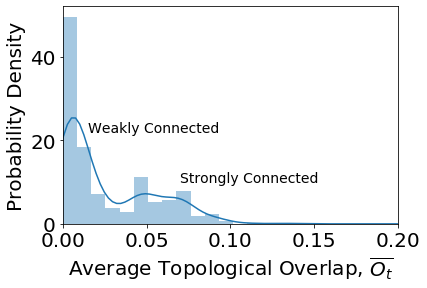

In [25]:
fig, ax = plt.subplots(1,1)

ax = sns.distplot(Otr.describe().loc['mean'])
ax.set_xlabel(r'Average Topological Overlap, $\overline{O_t}$',fontsize=20)
ax.set_ylabel('Probability Density',fontsize=20)
ax.text(0.015,22,'Weakly Connected',fontsize=14)
ax.text(0.07,10,'Strongly Connected',fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(0,0.2)
#plt.savefig('Ot_dist.pdf',bbox_inches='tight')

In [26]:
Ot_stats = Otr.describe()
ind = list(set(Otr.keys()).union(set(Ot.keys())))
ind.remove('ec_biomass_ijo1366_wt_53p95m')

avgOts = pd.DataFrame(columns = ['Ot','Type'], index = ind)

for rxn in Otr:
    
    if rxn == 'ec_biomass_ijo1366_wt_53p95m':
        continue
    
    avgOts.loc[rxn]['Ot'] = Ot_stats[rxn]['mean']
    
    if rxn not in reg_network['Id'].values:
        avgOts.loc[rxn]['Type'] = 'unregulated'
    elif reg_network[reg_network['Id']==rxn].indegree.values > 0 and reg_network[reg_network['Id']==rxn].outdegree.values > 0:
        avgOts.loc[rxn]['Type'] = 'both'
    elif reg_network[reg_network['Id']==rxn].indegree.values > 0:
        avgOts.loc[rxn]['Type'] = 'regulated'
    elif reg_network[reg_network['Id']==rxn].outdegree.values > 0:
        avgOts.loc[rxn]['Type'] = 'regulator'

In [27]:
scipy.stats.mannwhitneyu(Otm.describe().loc['mean'],avgOts['Ot'],alternative='greater')

MannwhitneyuResult(statistic=620830.5, pvalue=1.0431508637644337e-33)

In [28]:
Otspan = np.linspace(min(avgOts['Ot'].values),max(avgOts['Ot'].values),100)
freq_or = []
freq_ed = []

for i in range(0,len(Otspan)-1):
    minimum = Otspan[i]
    maximum = Otspan[i+1]
    
    temp = avgOts[avgOts['Ot'] > minimum]
    types = temp[temp['Ot'] <= maximum].Type.values
    
    if len(types) ==0:
        continue
    else:
        freq_or.append((maximum, len([x for x in types if x == 'both'or x == 'regulator'])/len(types)))
        freq_ed.append((maximum, len([x for x in types if x == 'regulated'])/len(types)))

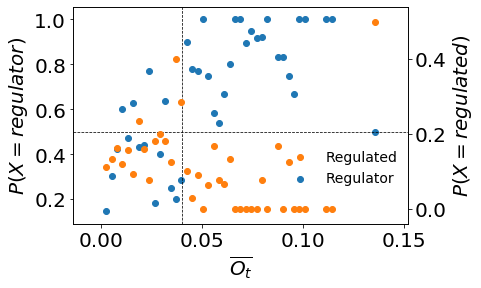

In [29]:
fig,ax = plt.subplots(1,1)

ax1=ax.twinx()

ax.scatter([x[0] for x in freq_or][:-1],[x[1] for x in freq_or][:-1],label='Regulator')
ax1.scatter([x[0] for x in freq_ed][:-1],[x[1] for x in freq_ed][:-1],color='C00001',label='Regulated')
#ax.set_xlim(0,0.17)
ax.axhline(0.5,linewidth=0.75,linestyle='--',color='k')
ax.axvline(0.04,linewidth=0.75,linestyle='--',color='k')
ax.legend(frameon=False,fontsize=14,loc = (0.62,0.15))
ax1.legend(frameon=False,fontsize=14,loc = (0.62,0.25))

ax.set_xlabel(r'$\overline{O_t}$',fontsize=20)
ax.set_ylabel(r'$P(X=regulator)$',fontsize=20)
ax1.set_ylabel(r'$P(X=regulated)$',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax1.tick_params(axis='y', which='major', labelsize=20)

#plt.savefig('P-Ot.pdf',bbox_inches='tight')

In [30]:
Ot_reg_nonreg = []
Ot_reg_reg = []

for i, row in network[network['type'] != 'reaction'].iterrows():
    source = row['start']
    target = row['end']
    
    if target in avgOts[avgOts['Type']=='regulated'].index:
        if np.isnan(avgOts.loc[source]['Ot']) or np.isnan(avgOts.loc[target]['Ot']):
            continue
        else:
            Ot_reg_nonreg.append((avgOts.loc[source]['Ot'],avgOts.loc[target]['Ot']))
    elif target in avgOts[avgOts['Type']=='both'].index:
        if np.isnan(avgOts.loc[source]['Ot']) or np.isnan(avgOts.loc[target]['Ot']):
            continue
        else:
            Ot_reg_reg.append((avgOts.loc[source]['Ot'],avgOts.loc[target]['Ot']))
    else:
        continue

In [31]:
regregrand = []
regnonregrand = []

pvals_regreg = []
pvals_regnonreg = []

i = random.randint(0,1000)

for i in range(0,1000):
    
    for (source, target) in ensemble[i].edges:
        if ensemble[i].out_degree[source] > 0 and ensemble[i].out_degree[target] > 0: #If both have out-edges
            regregrand.append((avgOts.loc[source]['Ot'], avgOts.loc[target]['Ot']))
        if ensemble[i].out_degree[source] > 0 and ensemble[i].out_degree[target] == 0: #If the target doesn't have out-edges
            regnonregrand.append((avgOts.loc[source]['Ot'], avgOts.loc[target]['Ot']))

    pvals_regnonreg.append(scipy.stats.mannwhitneyu([x[0]-x[1] for x in Ot_reg_nonreg],
                         [x[0]-x[1] for x in regnonregrand if np.isnan(x[0]-x[1]) == False]).pvalue)
    
    pvals_regreg.append(scipy.stats.mannwhitneyu([x[0]-x[1] for x in Ot_reg_reg],
                         [x[0]-x[1] for x in regregrand if np.isnan(x[0]-x[1]) == False]).pvalue)

In [32]:
print(len([x for x in pvals_regnonreg if x < 0.05])/1000)

1.0


In [33]:
print(len([x for x in pvals_regreg if x < 0.05])/1000)

1.0


In [34]:
regregrand = []
regnonregrand = []

for (source, target) in ensemble[220].edges:
    if ensemble[100].out_degree[source] > 0 and ensemble[100].out_degree[target] > 0: #If both have out-edges
        regregrand.append((avgOts.loc[source]['Ot'], avgOts.loc[target]['Ot']))
    if ensemble[100].out_degree[source] > 0 and ensemble[100].out_degree[target] == 0: #If the target doesn't have out-edges
        regnonregrand.append((avgOts.loc[source]['Ot'], avgOts.loc[target]['Ot']))

Text(0, 0.5, '$\\Delta \\overline{O_t}$')

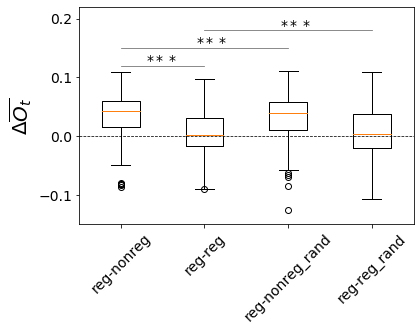

In [35]:
fig, ax = plt.subplots(1,1)

ax.boxplot([[x[0]-x[1] for x in Ot_reg_nonreg],[x[0]-x[1] for x in Ot_reg_reg],
               [x[0]-x[1] for x in regnonregrand if np.isnan(x[0]-x[1]) == False],
               [x[0]-x[1] for x in regregrand if np.isnan(x[0]-x[1]) == False]])
ax.plot([1, 3], [0.15, 0.15], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(1.9,0.155,r'$***$',fontsize=14)

ax.plot([1, 2], [0.12, 0.12], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(1.3,0.125,r'$***$',fontsize=14)

ax.plot([2, 4], [0.18, 0.18], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(2.9,0.185,r'$***$',fontsize=14)

ax.set_ylim(-0.15,0.22)

ax.tick_params(axis='both', which='major', labelsize=14)
ax.axhline(0,color='k',linewidth=0.75,linestyle='--')
plt.xticks([1, 2, 3, 4], ['reg-nonreg', 'reg-reg', 'reg-nonreg_rand','reg-reg_rand'],rotation=45)

ax.set_ylabel('$\Delta \overline{O_t}$',fontsize=20)

#plt.savefig('deltaOt.pdf',bbox_inches='tight')

In [36]:
scipy.stats.mannwhitneyu([x[0]-x[1] for x in Ot_reg_nonreg],
                         [x[0]-x[1] for x in regnonregrand if np.isnan(x[0]-x[1]) == False],alternative='greater')

MannwhitneyuResult(statistic=802185.5, pvalue=0.016806876396921622)

In [37]:
scipy.stats.ks_2samp([x[0]-x[1] for x in Ot_reg_nonreg],
                         [x[0]-x[1] for x in regnonregrand if np.isnan(x[0]-x[1]) == False])

Ks_2sampResult(statistic=0.06117366046492767, pvalue=0.018410353919379174)

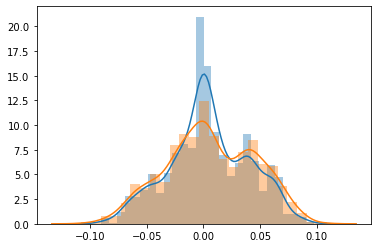

In [38]:
sns.distplot([x[0]-x[1] for x in Ot_reg_reg])#,cumulative=True)
sns.distplot([x[0]-x[1] for x in regregrand if np.isnan(x[0]-x[1]) == False])#,cumulative=True)
#plt.xlim(-0.1,0.1)

In [39]:
np.median([x[0]-x[1] for x in Ot_reg_reg])

0.0012033952086308378

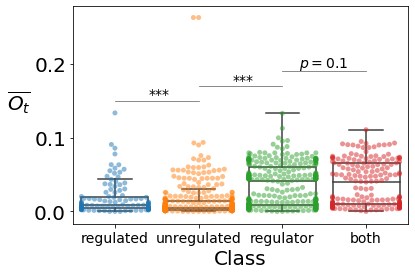

In [40]:
fig,ax = plt.subplots(1,1)
sns.boxplot(x="Type", y="Ot", data=avgOts, order=["regulated", "unregulated","regulator" , "both"], 
                 showcaps=True,boxprops={'facecolor':'None'},showfliers=False,ax=ax)
sns.swarmplot(x="Type", y="Ot", data=avgOts, order=["regulated", "unregulated","regulator" , "both"],ax=ax,alpha=0.5)

ax.plot([0, 1], [0.15, 0.15], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(0.4,0.153,'***',fontsize=14)

ax.plot([1, 2], [0.17, 0.17], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(1.4,0.173,'***',fontsize=14)

ax.plot([2, 3], [0.19, 0.19], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(2.2,0.196,r'$p=0.1$',fontsize=14)

ax.set_xlabel('Class',fontsize=20)
ax.set_ylabel(r'$\overline{O_t}$',fontsize=20,rotation=0,labelpad=15)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=14)

#plt.savefig('Ot-type.pdf',bbox_inches='tight')

In [41]:
scipy.stats.mannwhitneyu(avgOts[avgOts['Type']=='regulator'].Ot,avgOts[avgOts['Type']=='unregulated'].Ot)

MannwhitneyuResult(statistic=24965.5, pvalue=3.153968565188391e-35)

# Loop Analysis

In [42]:
loop_freq = []

for G in ensemble:
    
    x = loop_nodes(G)
    loop_freq.append(len(x)/len(G_rxn.nodes))

In [43]:
real_loop_nodes = loop_nodes(G_reg)

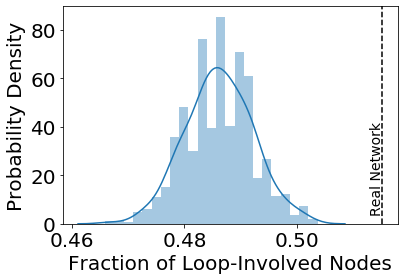

In [44]:
fig,ax = plt.subplots(1,1)

_=sns.distplot(loop_freq,ax=ax)
ax.axvline(len(real_loop_nodes)/len(G_rxn.nodes),color='k',linestyle='--')
ax.text(0.513,5,'Real Network',fontsize=14,rotation=90)

ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

ax.set_xlabel('Fraction of Loop-Involved Nodes',fontsize=20)
ax.set_ylabel('Probability Density',fontsize=20)

plt.savefig('loop-involved.pdf',bbox_inches='tight')

In [45]:
real_tally, loops = characterize_loops(G_reg)

In [46]:
ensemble_tally = [[],[],[],[],[],[],[],[]]
ensemble_tally_percents = [[],[],[],[],[],[],[],[]]

for net in ensemble:
    tally, _ = characterize_loops(net)
    for i in range(0,len(tally)):
        ensemble_tally[i].append(tally[i])
        ensemble_tally_percents[i].append(tally[i]/sum(tally))

In [47]:
ensemble_loops = pd.DataFrame(ensemble_tally,index=['C1','C2','C3','C4','I1','I2','I3','I4'])
real_loops = pd.DataFrame(real_tally,index=['C1','C2','C3','C4','I1','I2','I3','I4'])

In [48]:
np.std(loop_freq)

0.006088840827373502

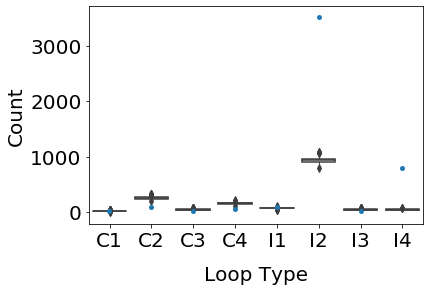

In [49]:
fig,ax = plt.subplots(1,1)

sns.boxplot(data=ensemble_loops.T, showcaps=False,boxprops={'facecolor':'None'},whiskerprops={'linewidth':1}, ax=ax) 
sns.swarmplot(data=real_loops.T,ax=ax,color='C00000')

ax.set_xlabel('Loop Type',fontsize=20, labelpad=15)
ax.set_ylabel('Count',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('loopcount.pdf',bbox_inches='tight')

In [63]:
real_loops

,0
C1,14
C2,92
C3,10
C4,46
I1,86
I2,3514
I3,10
I4,797


In [50]:
loop_diff = pd.DataFrame(columns=['C1','C2','C3','C4','I1','I2','I3','I4'])

for x in ['C1','C2','C3','C4','I1','I2','I3','I4']:
    loop_diff[x] = [real_loops.T[x].values-y for y in ensemble_loops.T[x]]

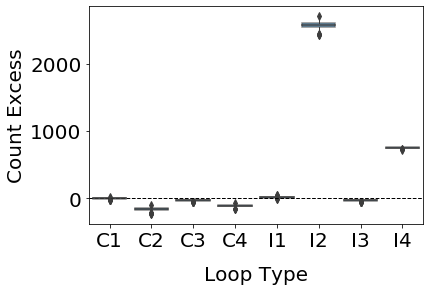

In [51]:
fig,ax = plt.subplots(1,1)

sns.boxplot(data=loop_diff, showcaps=False,boxprops={'facecolor':'C00000','alpha':0.6},whiskerprops={'linewidth':1}, ax=ax) 

ax.set_xlabel('Loop Type',fontsize=20, labelpad=15)
ax.set_ylabel('Count Excess',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.axhline(0,linewidth=1,linestyle='--',color='k')

plt.savefig('loopcount.pdf',bbox_inches='tight')

In [52]:
ensemble_loops_percents = pd.DataFrame(ensemble_tally_percents,index=['C1','C2','C3','C4','I1','I2','I3','I4'])
real_loops_percents = pd.DataFrame([x/sum(real_tally) for x in real_tally],index=['C1','C2','C3','C4','I1','I2','I3','I4'])

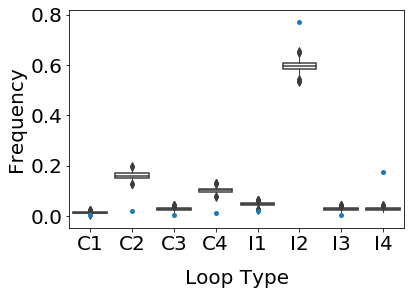

In [53]:
fig,ax = plt.subplots(1,1)

sns.boxplot(data=ensemble_loops_percents.T, showcaps=False,boxprops={'facecolor':'None'},whiskerprops={'linewidth':1},ax=ax) 
sns.swarmplot(data=real_loops_percents.T,ax=ax,color='C00000')

ax.set_xlabel('Loop Type',fontsize=20, labelpad=15)
ax.set_ylabel('Frequency',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('loopfreq.pdf',bbox_inches='tight')

In [54]:
in_node = []
coord_node = []
out_node = []

for kind in loops:
    for x in kind:
        if x[0] not in in_node and x[0] not in coord_node and x[0] not in out_node:
            in_node.append(x[0])
        if x[1] not in coord_node and x[1] not in in_node and x[1] not in out_node:
            coord_node.append(x[1])
        if x[2] not in out_node and x[2] not in coord_node and x[2] not in in_node:
            out_node.append(x[2])

C:\Users\euler\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\euler\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\euler\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\euler\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


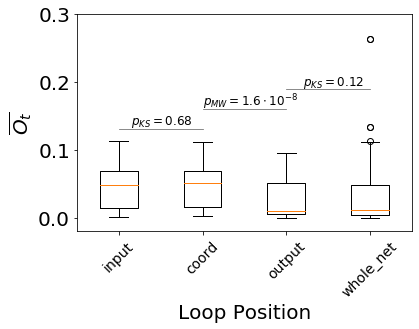

In [55]:
fig,ax = plt.subplots(1,1)

ax.boxplot([[avgOts.loc[x].Ot for x in in_node if np.isnan(avgOts.loc[x].Ot) == False],
               [avgOts.loc[x].Ot for x in coord_node if np.isnan(avgOts.loc[x].Ot) == False],
               [avgOts.loc[x].Ot for x in out_node if np.isnan(avgOts.loc[x].Ot) == False],
               avgOts['Ot']])

ax.plot([1, 2], [0.13, 0.13], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(1.15,0.137,r'$p_{KS}=0.68$',fontsize=12)

ax.plot([2, 3], [0.16, 0.16], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(2,0.165,r'$p_{MW}=1.6\cdot10^{-8}$',fontsize=12)

ax.plot([3, 4], [0.19, 0.19], color='k', linestyle='-', linewidth=0.75,alpha=0.6)
ax.text(3.2,0.195,r'$p_{KS} = 0.12$',fontsize=12)

ax.set_ylim(-0.02,0.3)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('$\overline{O_t}$',fontsize=20)
ax.set_xlabel('Loop Position',fontsize=20)
plt.xticks([1, 2, 3, 4], ['input', 'coord', 'output','whole_net'],rotation=45,fontsize=14)

plt.savefig('loopOt.pdf',bbox_inches='tight')

In [56]:
scipy.stats.ks_2samp([avgOts.loc[x].Ot for x in out_node if np.isnan(avgOts.loc[x].Ot) == False], 
                     avgOts['Ot'])

Ks_2sampResult(statistic=0.05731204943357363, pvalue=0.9558417814580135)

In [57]:
scipy.stats.mannwhitneyu([avgOts.loc[x].Ot for x in coord_node if np.isnan(avgOts.loc[x].Ot) == False], 
                         avgOts['Ot'])

MannwhitneyuResult(statistic=14364.5, pvalue=2.9513157906382413e-08)

In [58]:
scipy.stats.ks_2samp([avgOts.loc[x].Ot for x in in_node if np.isnan(avgOts.loc[x].Ot) == False],
                     [avgOts.loc[x].Ot for x in coord_node if np.isnan(avgOts.loc[x].Ot) == False])

Ks_2sampResult(statistic=0.10679245283018868, pvalue=0.678734835313421)

In [59]:
in_node

['asnn',
 'pdx5poi',
 'pyam5po',
 'fruk',
 'pfk',
 'ab6pgh',
 'r00838',
 'psd120',
 'psd160',
 'psd161',
 'psd181',
 'ca2tex',
 'cobalt2tex',
 'bmocos',
 'cu2tex',
 'mocos',
 'fe3hoxr1',
 'fe3hoxr2',
 'fe3hoxr3',
 'feoxamr2',
 'lipos',
 'mg2tex',
 'mntex',
 'zn2tex',
 'r00968',
 'gmps2',
 'ans',
 'aspta',
 'bts5',
 'cpppgo2',
 'hcysmt',
 'tyrl',
 'psp_l',
 'icl',
 'psert',
 'fesd1s',
 'ppck',
 'tkt2',
 'tgbpa',
 'grxr',
 'selgthr',
 'fclpa',
 'g3pd2',
 'g3pd5',
 'rmpa',
 'r02262',
 'r02263',
 'asns1',
 'mcitl2',
 'ichort',
 'cs',
 'allulpe',
 'sbtpd',
 'tala',
 'glyox',
 'gthor',
 'selgthr2',
 'selgthr3',
 'gmpr',
 'acact8r',
 'metat',
 'adcl',
 'alata_d2',
 'chrpl',
 'eda',
 'glcral',
 'hopntal',
 'ldh_d',
 'mcpst',
 'shchcs3',
 'vpamtr',
 'r03106',
 'ethaal',
 '3oxcoat',
 'acald',
 'oxdhcoat',
 'por5',
 'datphs',
 'dctpd',
 'dhppda2',
 'glycl',
 'nnam',
 'ntrir2x',
 'cyssads',
 'icysds',
 'scysds',
 'ahcysns',
 'ampn',
 'mtan',
 'adss',
 'cytdk2',
 'ppgppdp',
 'sadt2',
 'r00439',
 'u

In [60]:
os.chdir('C:\\Users\\euler\\Documents\\Project\\Flux-Sensing')

In [61]:
thermo=pd.read_csv('thermo.csv',index_col='index')

In [62]:
reg_network

,Id,Label,timeset,indegree,outdegree,Degree,weighted indegree,weighted outdegree,Weighted Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,Authority,Hub,modularity_class,pageranks,componentnumber,strongcompnum,clustering
0,gludc,gludc,NaN,14,2,16,14,2,16,8,0.221639,0.252522,480.348840,0.029448,0.001762,4,0.000732,0,100,0.050000
1,pants,pants,NaN,31,2,33,31,2,33,1,1.000000,1.000000,13.966667,0.044790,0.009440,4,0.002683,0,74,0.047379
2,asnn,asnn,NaN,33,17,50,33,17,50,7,0.270860,0.333536,2294.573641,0.083675,0.049604,0,0.003727,0,100,0.167633
3,asnnpp,asnnpp,NaN,33,17,50,33,17,50,7,0.270860,0.333536,2294.573641,0.083675,0.049604,0,0.003727,0,100,0.167633
4,sucasptpp,sucasptpp,NaN,0,19,19,0,19,19,7,0.284946,0.362073,0.000000,0.000000,0.043984,0,0.000500,0,101,0.137427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,airc2,airc2,NaN,2,0,2,2,0,2,0,0.000000,0.000000,0.000000,0.001632,0.000000,4,0.000943,0,144,0.000000
619,rbfsb,rbfsb,NaN,0,1,1,0,1,1,1,1.000000,1.000000,0.000000,0.000000,0.000064,4,0.000500,0,510,0.000000
620,fmnrx,fmnrx,NaN,3,0,3,3,0,3,0,0.000000,0.000000,0.000000,0.003394,0.000000,4,0.000746,0,142,0.000000
621,alatrs,alatrs,NaN,1,0,1,1,0,1,0,0.000000,0.000000,0.000000,0.000192,0.000000,7,0.000558,0,56,0.000000


In [151]:
#G_in = []
#G_coord = []
#G_out = []
#reg_all = []
#rxn_all = []
#regs = []
reged = []

for node in [x for x in avgOts.index if avgOts.loc[x]['Type'] == 'regulated']:
    
    if node in [x for x in G_rxn.nodes()]:
        neighbors = [x for x in G_rxn.neighbors(node)]
    else:
        continue
    
    temp = []
    for neighbor in neighbors:
        
        if neighbor in thermo.index.values:
            temp.append(thermo.loc[neighbor].delG)     
    if len(temp) == 0:
        continue
    else:
        reged.append((node,max(temp)))
#test

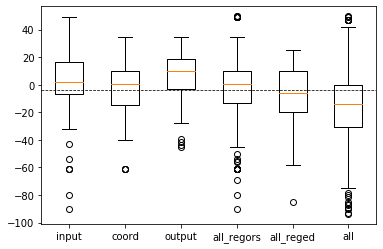

In [175]:
_ = plt.boxplot([[x[1] for x in G_in if x[1] >-100 and x[1] <200],
             [x[1] for x in G_coord if x[1] >-100 and x[1] <200],
             [x[1] for x in G_out if x[1] >-100 and x[1] <200],
                  [x[1] for x in regs if x[1] >-100 and x[1] <200],
               [x[1] for x in reged if x[1] > -100 and x[1] < 200],
                 [x for x in test['delG'] if x >-100 and x <200]])

_ = plt.xticks([1, 2, 3,4,5,6], ['input', 'coord', 'output','all_regors','all_reged','all'])
plt.axhline(-4,linewidth=0.75,linestyle='--',color='k')

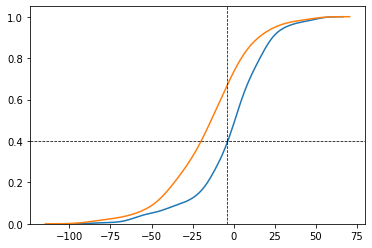

In [192]:
sns.kdeplot([x[1] for x in regs if x[1] > -100 and x[1] < 200],cumulative=True)
sns.kdeplot([x for x in test['delG'] if x > -100 and x < 200],cumulative=True)
plt.axvline(-4,linewidth=0.75,linestyle='--',color='k')
plt.axhline(0.4,linewidth=0.75,linestyle='--',color='k')

In [201]:
check = [(avgOts.loc[x]['Ot'],test.loc[x]['delG']) for x in test.index if x in avgOts.index]

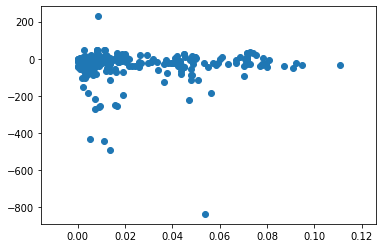

In [202]:
plt.scatter([x[0] for x in check],[x[1] for x in check])

In [155]:
scipy.stats.mannwhitneyu([x[1] for x in G_in],
                         [x for x in thermo['delG']])

MannwhitneyuResult(statistic=26591.0, pvalue=2.4256447608655036e-16)

In [147]:
len(thermo)/len(rxn_network)

0.6083769633507854

In [173]:
index = thermo.index
condition = thermo['error'] >= 100000
to_remove = index[condition].tolist()

print(to_remove)

['ex_mobd_e', 'acbipgt', 'aconmt', 'adocbik', 'adocbls', 'ap5ah', 'apcs', 'atpprt', 'cdgr', 'cyanst', 'dhbs', 'dhptdnr', 'dhptdnrn', 'entcs', 'lipatpt', 'mecdps', 'mobdabcpp', 'mobdtex', 'ntptp1', 'ntptp2', 'ohphm', 'ppa2', 'ppk2r', 'pppgo', 'pppgo3', 'ppthpp', 'prampc', 'pratpp', 'selnps', 'shchd2', 'spms', 'spodm', 'upp3mt', 'upp3s']


In [174]:
test = thermo.drop(to_remove)
test

,delG,error
index,,
ex_14glucan_e,867.628636,3.730814
14glucanabcpp,842.794992,3.743710
14glucantexi,-867.628636,3.730814
23pde2pp,-35.499553,3.014207
23pde4pp,-34.439193,3.014207
...,...,...
urdglycd,-7.816270,5.469727
uric,-92.695144,8.886327
urik2,-15.427780,4.432886


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['adp_c', 'h_c', 'pi_c', 'ppi_c']
[]
[]
[]
[]
['adp_c', 'h_c', 'pi_c', 'ppi_c']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['12dgr120_c']
['12dgr140_c']
['12dgr141_c']
['12dgr160_c']
['12dgr161_c']
['12dgr180_c']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['12dgr181_c']
['12ppd__R_p']
['12ppd__R_c']
[]
['12ppd__S_p']
['12ppd__S_c']
['14glucan_c', 'adp_c', 'h_c', 'pi_c']
[]
[]

In [120]:
f = open("reaction.txt", "r")
reactions = [x.split('\t') for x in f.read().split('\n')]
reactions

[['rn:R00001',
  'polyphosphate polyphosphohydrolase; Polyphosphate + n H2O <=> (n+1) Oligophosphate'],
 ['rn:R00002',
  'Reduced ferredoxin:dinitrogen oxidoreductase (ATP-hydrolysing); 16 ATP + 16 H2O + 8 Reduced ferredoxin <=> 8 e- + 16 Orthophosphate + 16 ADP + 8 Oxidized ferredoxin'],
 ['rn:R00004',
  'diphosphate phosphohydrolase; pyrophosphate phosphohydrolase; Diphosphate + H2O <=> 2 Orthophosphate'],
 ['rn:R00005',
  'urea-1-carboxylate amidohydrolase; Urea-1-carboxylate + H2O <=> 2 CO2 + 2 Ammonia'],
 ['rn:R00006',
  'pyruvate:pyruvate acetaldehydetransferase (decarboxylating); 2-acetolactate pyruvate-lyase (carboxylating); 2-Acetolactate + CO2 <=> 2 Pyruvate'],
 ['rn:R00008',
  '4-hydroxy-4-methyl-2-oxoglutarate pyruvate-lyase (pyruvate-forming); Parapyruvate <=> 2 Pyruvate'],
 ['rn:R00009',
  'hydrogen-peroxide:hydrogen-peroxide oxidoreductase; 2 Hydrogen peroxide <=> Oxygen + 2 H2O'],
 ['rn:R00010',
  'alpha,alpha-trehalose glucohydrolase; alpha,alpha-Trehalose + H2O <=> 2 

In [124]:
for x in reactions:
    if x[0][3:] in delG.keys():
        print(delG[x[0][3:]])

(-745.3, 47.4)
(-15.8, 0.4)
(-78.5, 15.1)
(32.3, 7.4)
(16.3, 4.6)
(-193.1, 13.3)
(-11.7, 2.1)
(-19.6, 8.8)
(-29.5, 6.8)
(-6.1, 10.7)
(-0.9, 8.0)
(18.0, 13.0)
(66.0, 11.8)
(-13.8, 10.8)
(-28.4, 7.5)
(-12.9, 3.7)
(7.8, 10.2)
(-14.6, 3.1)
(-519.3, 19.4)
(-364.5, 45.1)
(-110.3, 8.4)
(-109.5, 7.9)
(-10.0, 2.3)
(1.0, 13.3)
(-670.7, 22.1)
(-368.5, 6.5)
(-478.6, 9.0)
(-381.6, 24.0)
(-49.3, 9.7)
(-8.2, 2.9)
(-56.8, 6.1)
(-57.1, 6.1)
(-424.0, 14.3)
(-270.5, 33.9)
(3.5, 3.3)
(0.0, 0.0)
(-6.5, 27.8)
(-162.7, 44.1)
(98.7, 5.8)
(161.3, 12.9)
(-671.0, 43.9)
(-169.0, 8.5)
(-46.9, 33.5)
(-128.7, 16.2)
(-50.2, 1.2)
(-26.4, 0.6)
(-34.4, 1.1)
(-57.8, 7.0)
(7.0, 2.0)
(-326.5, 6.4)
(-6.4, 29.7)
(206.5, 16.4)
(49.4, 1.8)
(16.4, 1.7)
(-35.0, 8.7)
(-36.0, 5.9)
(-11.8, 5.8)
(-10.8, 5.8)
(-1.0, 0.7)
(-327.5, 6.5)
(50.3, 1.9)
(17.4, 1.6)
(-14.6, 5.8)
(-32.6, 9.3)
(-117.0, 8.4)
(-23.8, 0.6)
(-61.5, 7.6)
(-35.8, 18.3)
(9.5, 18.3)
(-2.6, 0.3)
(-32.4, 5.8)
(-55.2, 13.5)
(3.7, 5.8)
(-29.9, 9.0)
(3.2, 8.4)
(-13.1, 6.5)

(-21.2, 9.4)
(-63.2, 5.3)
(-11.5, 4.3)
(-11.5, 4.3)
(-7.6, 15.1)
(-66.5, 5.5)
(-13.6, 4.3)
(-11.5, 4.3)
(-11.5, 4.3)
(-13.6, 4.3)
(-3.3, 4.7)
(-21.2, 9.4)
(-63.2, 5.3)
(-13.7, 9.3)
(-3.5, 4.7)
(-101.6, 3.5)
(-13.7, 9.3)
(-14.6, 4.7)
(-67.8, 5.6)
(-13.7, 9.3)
(-19.6, 6.1)
(8.9, 4.9)
(-895.0, 4.9)
(32.8, 8.2)
(17.6, 5.8)
(79.1, 7.9)
(58.4, 1.9)
(58.4, 1.9)
(-442.3, 7.0)
(8.7, 17.1)
(-222.7, 6.9)
(-219.6, 6.8)
(-11.0, 6.5)
(-3.5, 6.2)
(-8.4, 0.8)
(-266.6, 12.5)
(-203.2, 3.6)
(-25.0, 11.6)
(-406.9, 9.8)
(-395.3, 6.1)
(3.2, 3.7)
(-372.8, 6.7)
(-299.8, 1.6)
(-406.9, 9.8)
(-469.4, 6.3)
(-398.4, 6.1)
(20.1, 1.9)
(-430.5, 7.0)
(-67.7, 6.1)
(-17.0, 2.6)
(-0.7, 2.9)
(97.6, 11.6)
(181.7, 23.2)
(-388.5, 13.5)
(-375.0, 3.0)
(-424.3, 9.1)
(-40.5, 4.1)
(-3.1, 15.4)
(-4.8, 3.3)
(3.2, 3.7)
(-43.5, 1.6)
(-26.9, 5.6)
(-351.2, 12.5)
(-71.5, 12.4)
(-28.5, 12.5)
(-270.3, 8.7)
(9.9, 4.1)
(-36.9, 2.2)
(-452.3, 9.4)
(-395.3, 6.1)
(23.1, 2.0)
(-37.0, 2.2)
(-351.2, 12.5)
(-135.7, 12.3)
(-371.9, 12.0)
(72.0, 8.9)


In [123]:
delG.keys()

dict_keys(['R00002', 'R00004', 'R00005', 'R00006', 'R00008', 'R00009', 'R00010', 'R00013', 'R00014', 'R00015', 'R00016', 'R00018', 'R00019', 'R00021', 'R00022', 'R00024', 'R00026', 'R00027', 'R00028', 'R00031', 'R00032', 'R00033', 'R00036', 'R00038', 'R00039', 'R00042', 'R00043', 'R00044', 'R00045', 'R00048', 'R00049', 'R00053', 'R00054', 'R00055', 'R00058', 'R00059', 'R00062', 'R00063', 'R00066', 'R00067', 'R00069', 'R00070', 'R00072', 'R00078', 'R00084', 'R00085', 'R00086', 'R00087', 'R00088', 'R00089', 'R00090', 'R00091', 'R00092', 'R00093', 'R00094', 'R00102', 'R00103', 'R00104', 'R00105', 'R00112', 'R00113', 'R00114', 'R00115', 'R00118', 'R00119', 'R00120', 'R00122', 'R00123', 'R00125', 'R00126', 'R00127', 'R00128', 'R00129', 'R00130', 'R00131', 'R00132', 'R00134', 'R00137', 'R00139', 'R00140', 'R00149', 'R00150', 'R00153', 'R00155', 'R00156', 'R00157', 'R00158', 'R00159', 'R00160', 'R00161', 'R00173', 'R00174', 'R00178', 'R00181', 'R00182', 'R00183', 'R00184', 'R00185', 'R00188',

In [133]:
f = open("output_kegg_compounds.txt", "r")
temp = [x.split('\t') for x in f.read().split('\n')]
temp = temp[:-1]

In [136]:
thesaurus = {}

for x in temp:
    for name in [y.lower() for y in x[1].split(';')]:
        thesaurus[name] = x[0].lower()
thesaurus

{'h2o': 'c00001',
 'water': 'c00001',
 'atp': 'c00002',
 "adenosine 5'-triphosphate": 'c00002',
 'nad+': 'c00003',
 'nad': 'c00003',
 'nicotinamide adenine dinucleotide': 'c00003',
 'dpn': 'c00003',
 'diphosphopyridine nucleotide': 'c00003',
 'nadide': 'c00003',
 'beta-nad+': 'c00003',
 'nadh': 'c00004',
 'dpnh': 'c00004',
 'reduced nicotinamide adenine dinucleotide': 'c00004',
 'nadph': 'c00005',
 'tpnh': 'c00005',
 'reduced nicotinamide adenine dinucleotide phosphate': 'c00005',
 'nadp+': 'c00006',
 'nadp': 'c00006',
 'nicotinamide adenine dinucleotide phosphate': 'c00006',
 'beta-nicotinamide adenine dinucleotide phosphate': 'c00006',
 'tpn': 'c11037',
 'triphosphopyridine nucleotide': 'c00006',
 'beta-nadp+': 'c00006',
 'oxygen': 'c00007',
 'o2': 'c00007',
 'adp': 'c00008',
 "adenosine 5'-diphosphate": 'c00008',
 'orthophosphate': 'c00009',
 'phosphate': 'c00009',
 'phosphoric acid': 'c00009',
 'orthophosphoric acid': 'c00009',
 'coa': 'c00010',
 'coenzyme a': 'c00010',
 'coa-sh': 

In [172]:
test = {}

for reaction in model.reactions:
    temp = []
    for reactant in reaction.reactants:
        if reactant.name.lower() in thesaurus.keys():
            temp.append(thesaurus[reactant.name.lower()])
        else:
            temp.append(reactant.name.lower())
    test[reaction.id] = temp
    
test

{'EX_cm_e': ['c00918'],
 'EX_cmp_e': ['cmp c9h12n3o8p'],
 'EX_co2_e': ['co2 co2'],
 'EX_cobalt2_e': ['c00175'],
 'DM_4crsol_c': ['c01468'],
 'DM_5drib_c': ["5'-deoxyribose"],
 'DM_aacald_c': ['c06735'],
 'DM_amob_c': ['c04425'],
 'DM_mththf_c': ['(2r,4s)-2-methyl-2,3,3,4-tetrahydroxytetrahydrofuran'],
 'EX_colipa_e': ['core oligosaccharide lipid a'],
 'DM_oxam_c': ['c01444'],
 'EX_glc__D_e': ['c00031'],
 'EX_glcn_e': ['c00257'],
 'BIOMASS_Ec_iJO1366_WT_53p95M': ['c00234',
  '2-demethylmenaquinol 8',
  '[2fe-2s] iron-sulfur cluster',
  '[4fe-4s] iron-sulfur cluster',
  'c00440',
  'c00024',
  'c00194',
  'c00041',
  'c00019',
  'c00062',
  'c00152',
  'c00049',
  'atp c10h12n5o13p3',
  'bis-molybdopterin guanine dinucleotide',
  'c00120',
  'calcium',
  'c00251',
  'c00698',
  'cardiolipin (tetrahexadecanoyl, n-c16:0)',
  'cardiolipin (tetrahexadec-9-enoyl, n-c16:1)',
  'cardiolipin (tetraoctadec-11-enoyl, n-c18:1)',
  'c00010',
  'c00175',
  'core oligosaccharide lipid a',
  'ctp c9h12

In [167]:
for reaction in model.reactions:
    for reactant in reaction.reactants:
        print(reactant.name)

Chloramphenicol
CMP C9H12N3O8P
CO2 CO2
Co2+
P-Cresol
5'-deoxyribose
Aminoacetaldehyde
S-Adenosyl-4-methylthio-2-oxobutanoate
(2R,4S)-2-methyl-2,3,3,4-tetrahydroxytetrahydrofuran
Core oligosaccharide lipid A
Oxamate
D-Glucose
D-Gluconate
10-Formyltetrahydrofolate
2-Demethylmenaquinol 8
[2Fe-2S] iron-sulfur cluster
[4Fe-4S] iron-sulfur cluster
5-Methyltetrahydrofolate
Acetyl-CoA
Adenosylcobalamin
L-Alanine
S-Adenosyl-L-methionine
L-Arginine
L-Asparagine
L-Aspartate
ATP C10H12N5O13P3
Bis-molybdopterin guanine dinucleotide
Biotin
Calcium
Chorismate
Chloride
Cardiolipin (tetrahexadecanoyl, n-C16:0)
Cardiolipin (tetrahexadec-9-enoyl, n-C16:1)
Cardiolipin (tetraoctadec-11-enoyl, n-C18:1)
Coenzyme A
Co2+
Core oligosaccharide lipid A
CTP C9H12N3O14P3
Copper
L-Cysteine
DATP C10H12N5O12P3
DCTP C9H12N3O13P3
DGTP C10H12N5O13P3
DTTP C10H13N2O14P3
Enterochelin
Flavin adenine dinucleotide oxidized
Fe2+ mitochondria
Iron (Fe3+)
L-Glutamine
L-Glutamate
Glycine
Glycogen C6H10O5
Reduced glutathione
GTP C1

H2O H2O
D-Malate
Acetyl-CoA
Glyoxylate
H2O H2O
Acetyl-CoA
Maltose C12H22O11
H+
Melibiose C12H22O11
1-hexadec-9-enoyl-sn-glycerol 3-phosphate
H2O H2O
H+
Melibiose C12H22O11
Melibiose C12H22O11
ATP C10H12N5O13P3
H2O H2O
Maltohexaose
Maltohexaose
ATP C10H12N5O13P3
H2O H2O
Maltopentaose
1-octadecanoyl-sn-glycerol 3-phosphate
H2O H2O
Maltopentaose
Methanol
Methanol
2-C-methyl-D-erythritol 4-phosphate
CTP C9H12N3O14P3
H+
ATP C10H12N5O13P3
H2O H2O
Maltotriose C18H32O16
Maltotriose C18H32O16
1-octadec-11-enoyl-sn-glycerol 3-phosphate
H2O H2O
ATP C10H12N5O13P3
H2O H2O
Maltotetraose
Maltotetraose
ATP C10H12N5O13P3
H2O H2O
Maltose C12H22O11
ATP C10H12N5O13P3
H2O H2O
L-Methionine
ATP C10H12N5O13P3
H2O H2O
D-Methionine
D-Methionine
Hydrogen peroxide
L-Methionine
Hydrogen peroxide
L-Methionine
Maltose C12H22O11
Phosphoenolpyruvate
Maltose C12H22O11
1-Acyl-sn-glycero-3-phosphoethanolamine (n-C12:0)
H2O H2O
H+
L-Malate
H+
L-Malate
5-Methyltetrahydrofolate
L-Homocysteine
ATP C10H12N5O13P3
H2O H2O
L-Met

In [174]:
len(in_node)

200

In [178]:
len(set(in_node).intersection(set(out_node)))

0